# Includable Transactions per Block

In [1]:
import pandas as pd
import numpy as np
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET PATH to master.csv.gz (input)
# SET PATH to filtered_finalized_txns.csv.gz (output)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
master_df = '/Volumes/Seagate/misc/master.csv.gz'

filtered_df = '/Volumes/Seagate/misc/filtered_finalized_txns.csv.gz'

## 1. Filter Master File
Note you only need to run the filtering cell once. Once you have stored filtered_finalized_txns.csv.gz, you can skip to the next cell to load it in

- Filters the master.csv.gz file to only include finalized transactions.
- Drops private transactions, non-finalized transactions, and duplicate confirmations.
- Drops the rows with the highest, top 1% of 'gasused' (extreme outliers).
- Converts 'blockspending' and 'maxfeepergas' to integers.
- Output: filtered_finalized_txns.csv.gz

In [ ]:
# DATA FILTERING - 
# You only need to run this cell once. After you create the filtered_finalized_txns.csv.gz file, you can skip this cell.

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# FILTER MASTER FILE
#~~~~~~~~~~~~~~~~~~~~~~~~~~
def filter_master_file(master_df, filtered_df):
    '''
    Filters the master.csv.gz file to include only finalized transactions.

    Removes private transactions, non-finalized events, and duplicate confirmations,
    keeping only the first occurrence of each unique hash.

    Converts 'blockspending' and 'maxfeepergas' columns to integers.

    Drops rows with the highest 1% of 'gasused' (extreme outliers).

    Output:
    - filtered_finalized_txns.csv.gz

    Parameters:
    - master_df (str): Path to the input master CSV file (compressed with gzip).
    - filtered_df (str): Path to the output filtered CSV file (compressed with gzip).

    Notes:
    - You only need to run this cell once to create the filtered_df file. After creating
      the file, you can skip this cell.
    '''

    # read in master file
    df = pd.read_csv(master_df, compression='gzip', sep='\t')

    # drop private transactions
    df = df[df['timepending'] > 0]

    # drop non finalized events and duplicate confirmations (keep the first one)
    df = df[(df['status'] == 'confirmed') | (df['status'] == 'failed')]
    df = df.drop_duplicates(subset=['hash'], keep='first')

    # convert these 2 columns to integers
    df['blockspending'] = df['blockspending'].astype(int)
    df['maxfeepergas'] = df['maxfeepergas'].astype(int)

    # drop the rows with the highest, top 1% of 'gasused' (extreme outliers)
    df = df[df['gasused'] < df['gasused'].quantile(0.99)]

    df = df.reset_index(drop=True)

    # store to smaller file
    df.to_csv(filtered_df, compression='gzip', sep='\t', index=False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# RUN FUNCTION
#~~~~~~~~~~~~~~~~~~~~~~~~~~
#filter_master_file(master_df, filtered_df)

## Load in the filtered df

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~
# LOAD FILTERED FILE
#~~~~~~~~~~~~~~~~~~~~~~~~~~
df = pd.read_csv(filtered_df, compression='gzip', sep='\t')

## 2. Get basefeepergas per curblocknumber

curblocknumber[i] has basefeepergas[i] 

Note: You only need to run this cell one time to create the pickle. After you've create the pickle, you can skip this cell.

In [ ]:
def get_bfpg_per_block(df):
    '''
    Computes and stores basefeepergas per block.

    This function takes a DataFrame `df`, extracts
    'curblocknumber' and 'basefeepergas' columns, removes duplicates, and sorts
    the data by 'curblocknumber'. It then checks if 'curblocknumber' is both
    monotonic increasing and sequential.

    The resulting 'curblocknumber' and 'basefeepergas' are stored in a pickle file
    named 'curblocknumber_basefeepergas.pickle'.

    curblocknumber[i] has basefeepergas[i] for all i.

    Parameters:
    - df (pd.DataFrame): A DataFrame containing at least 'curblocknumber' and
      'basefeepergas' columns.

    Output:
    - curblocknumber_basefeepergas.pickle

    Notes:
    - You only need to run this cell once to create the pickle. After creating
      the pickle, you can skip this cell.
    '''
    
    # Get a list of curblocknumber, basefeepergas
    curblocknumber = df['curblocknumber'].values
    basefeepergas = df['basefeepergas'].values

    # zip together the two arrays and remove duplicates
    zipped = list(zip(curblocknumber, basefeepergas))
    zipped = list(set(zipped))

    # sort zipped by curblocknumber
    zipped.sort(key=lambda x: x[0])

    curblocknumber, basefeepergas = zip(*zipped)

    # Check if curblocknumber is monotonic increasing and sequential (should be true)
    curblocknumber = np.array(curblocknumber)
    print("Is curblocknumber monotonic increasing?", np.all(np.diff(curblocknumber) > 0))
    print("Is curblocknumber sequential (no gaps)?", np.all(np.diff(curblocknumber) == 1))

    # store curblocknumber and basefeepergas in pickle file
    with open('curblocknumber_basefeepergas.pickle', 'wb') as f:
        pickle.dump((curblocknumber, basefeepergas), f)

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# RUN FUNCTION
#~~~~~~~~~~~~~~~~~~~~~~~~~~
#df = pd.read_csv(filtered_df, compression='gzip', sep='\t')
#get_bfpg_per_block(df)

## Load in the curblocknumber and basefeepergas

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Load the lists of curblocknumber, basefeepergas
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

curblocknumber = np.array(curblocknumber)
basefeepergas = np.array(basefeepergas)

In [ ]:
# check if the values in 'hash' are unique (should be True)
print("Are the values in 'hash' unique?", len(df['hash']) == len(set(df['hash'])))

## 3. Process Data (Calculate Includable Gas)

Note: You only need to run this cell once to create the file. Once you create the file you can skip this cell. 

Uncomment/run the last line in the cell to run the function

In [ ]:
def get_includable_txns_per_block(df, curblocknumber):
    '''
    Computes includable transactions per block.

    Given a DataFrame `df` representing filtered data and a numpy array `curblocknumber`
    containing unique block numbers, this function calculates the includable transactions per block.
    
    Includable transactions are those for which 'maxfeepergas' is greater than or equal
    to the corresponding 'basefeepergas' for the block. Gas per block (`gpb`), gas used per
    block (`gupb`), and the count of includable transactions (`txns`) are updated accordingly.

    The results, including the offset, `gpb`, `gupb`, and `txns`, are stored in a pickle
    file named 'includable_gas_arrays.pickle'.

    Parameters:
    - df (pd.DataFrame): A DataFrame containing relevant columns including 'curblocknumber',
      'blockspending', 'maxfeepergas', 'gas', and 'gasused'. This should be the filtered DataFrame.
    - curblocknumber (np.ndarray): A numpy array containing the unique block numbers,
      created in `get_bfpg_per_block` and stored in 'curblocknumber_basefeepergas.pickle'.

    Output:
    - includable_gas_arrays.pickle

    Notes:
    - You only need to run this cell once to create the pickle. After creating
      the pickle, you can skip this cell.
    '''
  
    # initliaze an np array of zeros of the length of curblocknumber
    # this will be the GPB array where blocknumber = index + offset
    gpb  = np.zeros(len(curblocknumber))    # gas per block (uses column 'gas')
    gupb = np.zeros(len(curblocknumber))    # gas used per block (uses column 'gasused')
    txns = np.zeros(len(curblocknumber))    # includable transactions per block (increases whenever a transaction is considered includable (MFPG >= BFPB))
    offset = curblocknumber[0]

    df_len = len(df)
    for index, row in df.iterrows():

        if index % 1000 == 0:
            print("\rcheckpoint at row {} of {}".format(index, df_len), end="")

        # get the last block (the block when the transaction is finalized (confirmed/failed))
        # note that the rows are finalized status so the 'curblocknumber' is the block that the transaction is included in. 
        last_block = row['curblocknumber']
        last_block_index = last_block - offset

        # get the first block (the block when the transaction is first pending)
        first_block = last_block - row['blockspending']
        first_block_index = first_block - offset

        # if the first block is negative, set it to 0 (txns that were pending before our sample started but finalized during our sample)
        if first_block_index < 0:
            first_block_index = 0

        # NEW: Make the assumption that blocks are generally not considered includable until the next block after entering the mempool    
        if first_block_index < last_block_index:   
            first_block_index += 1
            
        # for each block that the transaction was pending, if it is includable then add the gas to the GPB array, etc
        for block_index in range(first_block_index, last_block_index+1):
            # if the transaction is includable in the block
            if row['maxfeepergas'] >= basefeepergas[block_index]:
                gpb[block_index] += row['gas']      # add the gas to the GPB array for the block (using column gas)
                gupb[block_index] += row['gasused'] # add the gas used to the GUPB array for the block (using column gasused)
                txns[block_index] += 1              # increment the txns count for the block

    # store results: offset, gpb, gupb, txns to pickle file
    with open('includable_gas_arrays.pickle', 'wb') as f:
        pickle.dump((offset, gpb, gupb, txns), f)

#~~~~~~~~~~~~~~~~~~~~~~~~~~
# RUN FUNCTION
#~~~~~~~~~~~~~~~~~~~~~~~~~~
#df = pd.read_csv(filtered_df, compression='gzip', sep='\t')
#get_includable_txns_per_block(df, gpb, gupb, txns, offset)

# 4. Plots!

### Load in the files for plotting 

In [3]:
# load current block number and base fee per gas
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

curblocknumber = np.array(curblocknumber)
basefeepergas = np.array(basefeepergas)

In [4]:
# load results
with open('includable_gas_arrays.pickle', 'rb') as f:
    offset, gpb, gupb, txns = pickle.load(f)

# put oresults into a dataframe
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

### Set the color palette

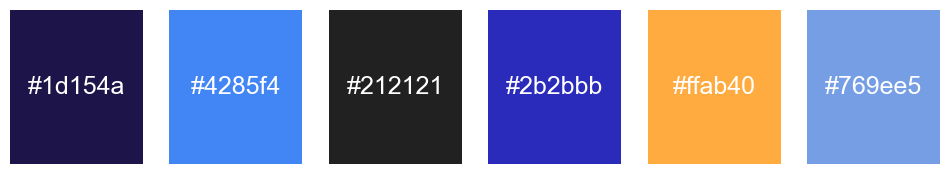

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

palette = ['#1d154a', '#4285f4', '#212121', '#2b2bbb', '#ffab40', '#769ee5']

fig, ax = plt.subplots(1, len(palette), figsize=(len(palette)*2, 2))

for i, color in enumerate(palette):
    rect = patches.Rectangle((0, 0), 1, 1, facecolor=color)
    ax[i].add_patch(rect)
    ax[i].text(0.5, 0.5, color, color='white', ha='center', va='center')
    ax[i].axis('off')

plt.show()

## Timeseries

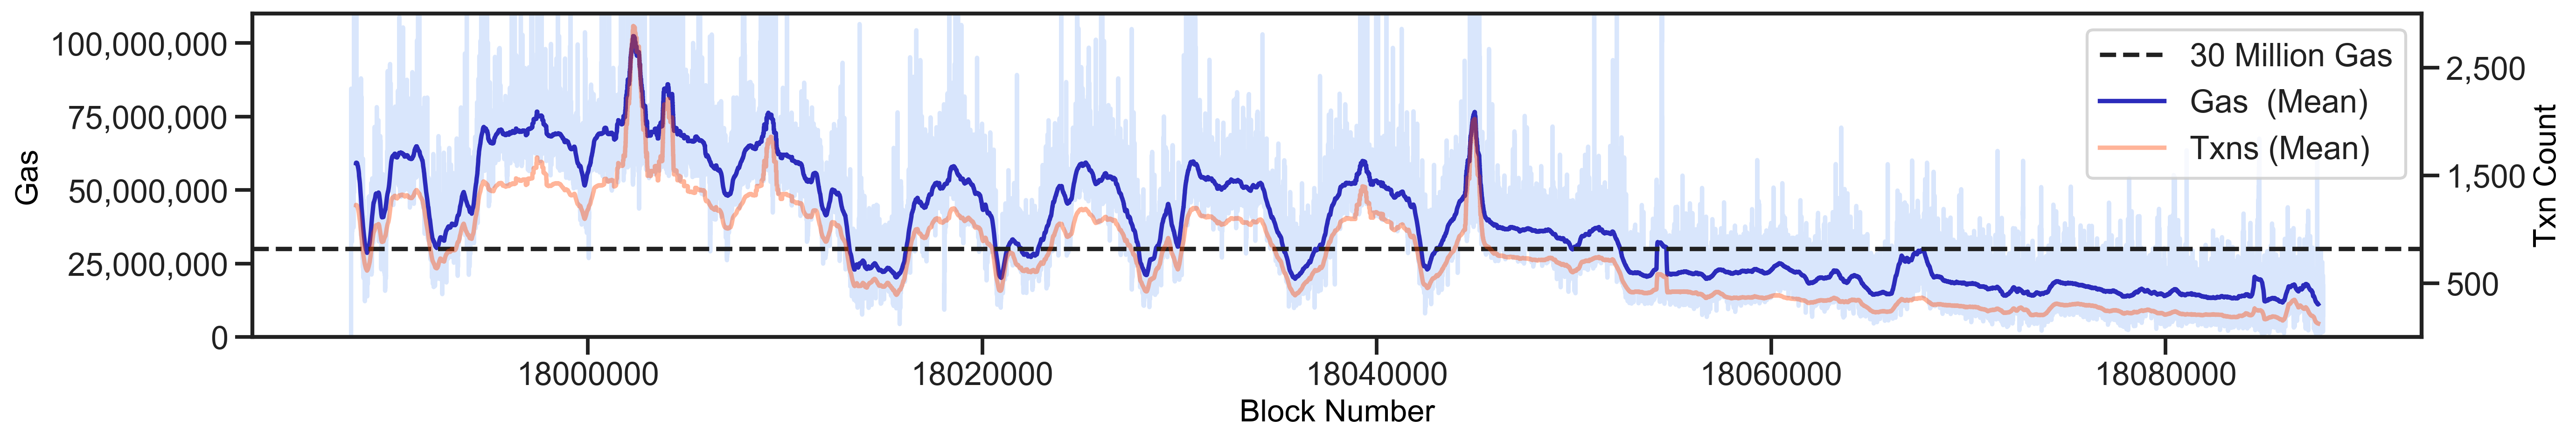

In [7]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')

fig, ax1 = plt.subplots(figsize=(20, 3), dpi=300)

# Create a rolling mean column with a larger window
# Plot the 'GUPB' on the first y-axis (left) with the rolling mean (moving average)
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()
ax1.plot(includable_df['Block'], includable_df['GUPB'],alpha = 0.2, color = palette[1])
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Gas  (Mean)', color = palette[3]) 

# Axis 
ax1.set_ylabel('Gas', color='black', fontsize=16)
ax1.set_xlabel('Block Number', color='black', fontsize=16)
ax1.set_ylim(0, 110000000)
# ax1.set_yticks([10000000, 30000000, 50000000, 70000000, 90000000])

# Style
ax1.tick_params(axis='both', colors=palette[2])
ax1.ticklabel_format(style='plain')
ax1.set_facecolor('white')
ax1.grid(False)

# Plot the 'Txn Count' on the second y-axis (right)
ax2 = ax1.twinx()
includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Txns (Mean)', color = 'orangered', alpha = 0.4, zorder=0)  

# Axis 
ax2.set_ylabel('Txn Count', color='black', fontsize=16)
ax2.set_ylim(0, 3000)
ax2.set_yticks([500,1500,2500])

# Style
ax2.set_facecolor('white')
ax2.grid(False)

# Plot a horizontal line to mark 30 million gas
ax1.axhline(30000000, linestyle='--', label='30 Million Gas', zorder=4, color = palette[2] )

# Set the spines to black
for spine in ax2.spines.values():
    spine.set_edgecolor(palette[2])
    spine.set_linewidth(2)

# Define a function to format y-axis labels
def comma_format(x, pos):
    return '{:,}'.format(int(x))

# Create a formatter
formatter = FuncFormatter(comma_format)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Get legend handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Move '30 Million Gas' handle and label
index = labels.index('30 Million Gas')
handle = handles.pop(index)
label = labels.pop(index)
handles.insert(0, handle)
labels.insert(0, label)

# Create a single legend
legend = ax1.legend(handles, labels, loc='upper right', facecolor='white')
for text in legend.get_texts():
    text.set_color(palette[2])

# Set the color of the tick lines on both axes to black
ax1.tick_params(axis='both', colors=palette[2])
ax2.tick_params(axis='both', colors=palette[2])
ax1.tick_params(axis='x', colors=palette[2])
ax2.tick_params(axis='x', colors=palette[2])


plt.show()
fig.savefig('../figures/includable_gas_and_txn_count_14days.png', dpi=300, bbox_inches='tight', transparent=True)
plt.close()

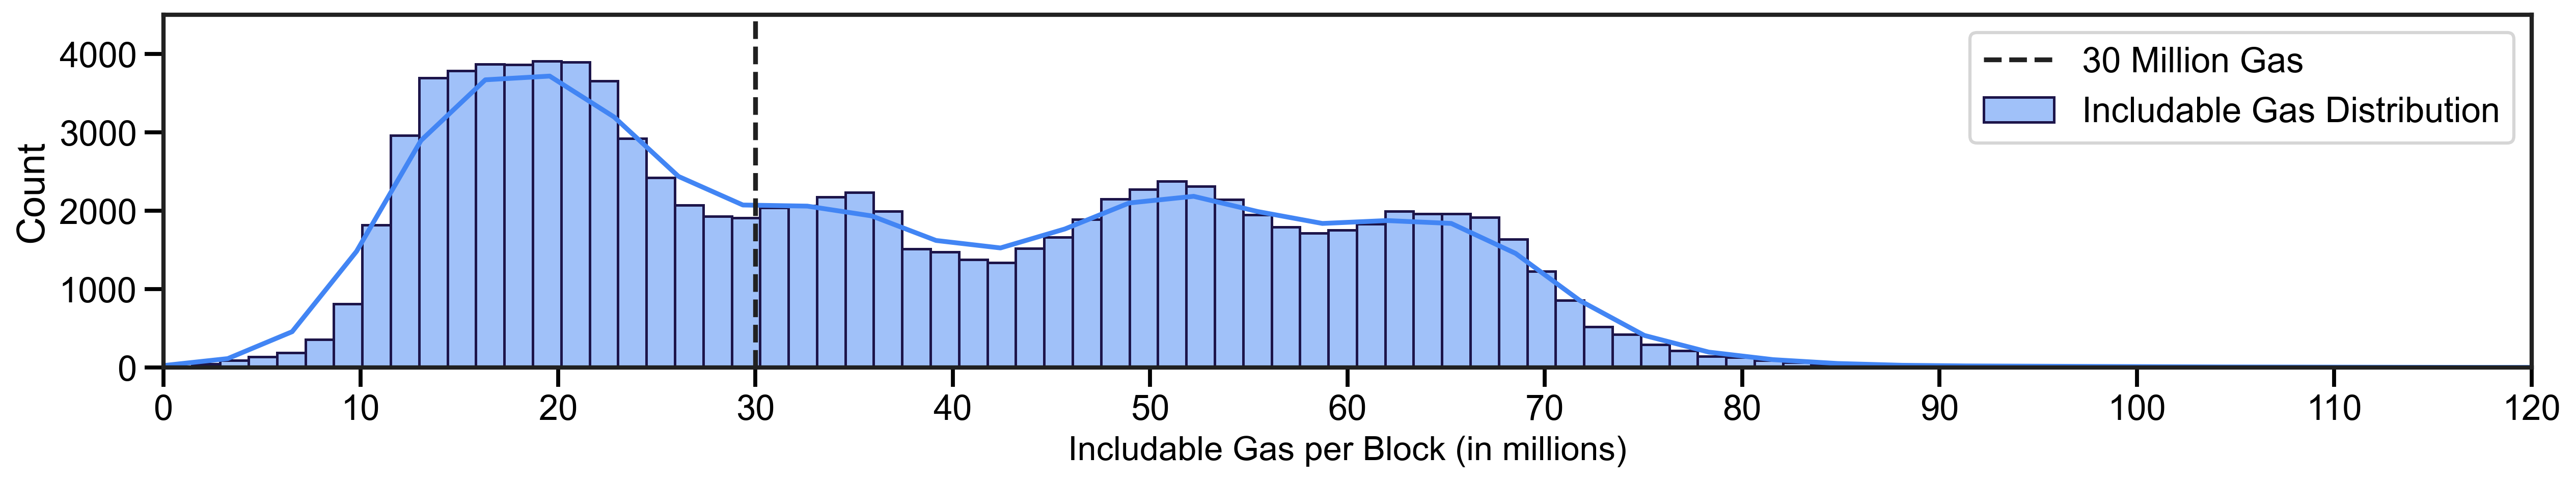

In [8]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')


plt.subplots(figsize=(20, 3), dpi=300)

sns.histplot(includable_df['GUPB'], bins='auto', kde=True, edgecolor=palette[0], linewidth=1.2, color=palette[1], label='Includable Gas Distribution')
plt.axvline(30000000, linestyle='--', label='30 Million Gas', color = palette[2]) 

plt.xticks(np.arange(0, includable_df['GUPB'].max(), 10000000)) 
plt.xlim(0, 120000000)
plt.ylim(0, 4500)
# plt.ylim(0, 2000)

plt.xlabel('Includable Gas per Block', color='black', fontsize=16)
plt.ticklabel_format(style='plain')

# Define a function to format x-axis labels
def comma_format(x, pos):
    # Divide by 1,000,000, round to the nearest integer, and format
    return '{:,}'.format(int(round(x / 1000000)))

# Create a formatter
formatter = FuncFormatter(comma_format)

# Get the current axes
ax = plt.gca()

# Set the formatter for the x-axis
ax.xaxis.set_major_formatter(formatter)
ax.grid(False)
ax.set_facecolor('white')

# Set the spines to black
for spine in ax.spines.values():
    spine.set_edgecolor(palette[2])
    spine.set_linewidth(2)

# show legend
plt.legend(loc='upper right', facecolor='white')

plt.xlabel('Includable Gas per Block (in millions)', color='black', fontsize=16)

plt.savefig('../figures/includable_gas_distribution_14days.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [9]:
# # print the summary stats about includable_df['GUPB']
# print("Summary Statistics for Includable Gas per Block")
# print(includable_df['GUPB'].describe())

# print the % of includable_df['GUPB'] >= 30 million
print("Percentage of Includable Gas per Block >= 30 Million")
free_gas = len(includable_df[includable_df['GUPB'] >= 30000000]) / len(includable_df) * 100
print("{:.2f}%".format(free_gas))


Percentage of Includable Gas per Block >= 30 Million
55.92%


### Subset Data in thirds

https://mempool.jhoenicke.de/#ETH,3m,count,7

This dashboard suggests the end of August 2023 was particularily with high numbers of transactions that drop down at the start of September

In [16]:
with open('includable_gas_arrays.pickle', 'rb') as f:
    offset, gpb, gupb, txns = pickle.load(f)
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

df_len = len(includable_df)


includable_df = includable_df.loc[df_len//1.5:]
# includable_df = includable_df.loc[:df_len//3]

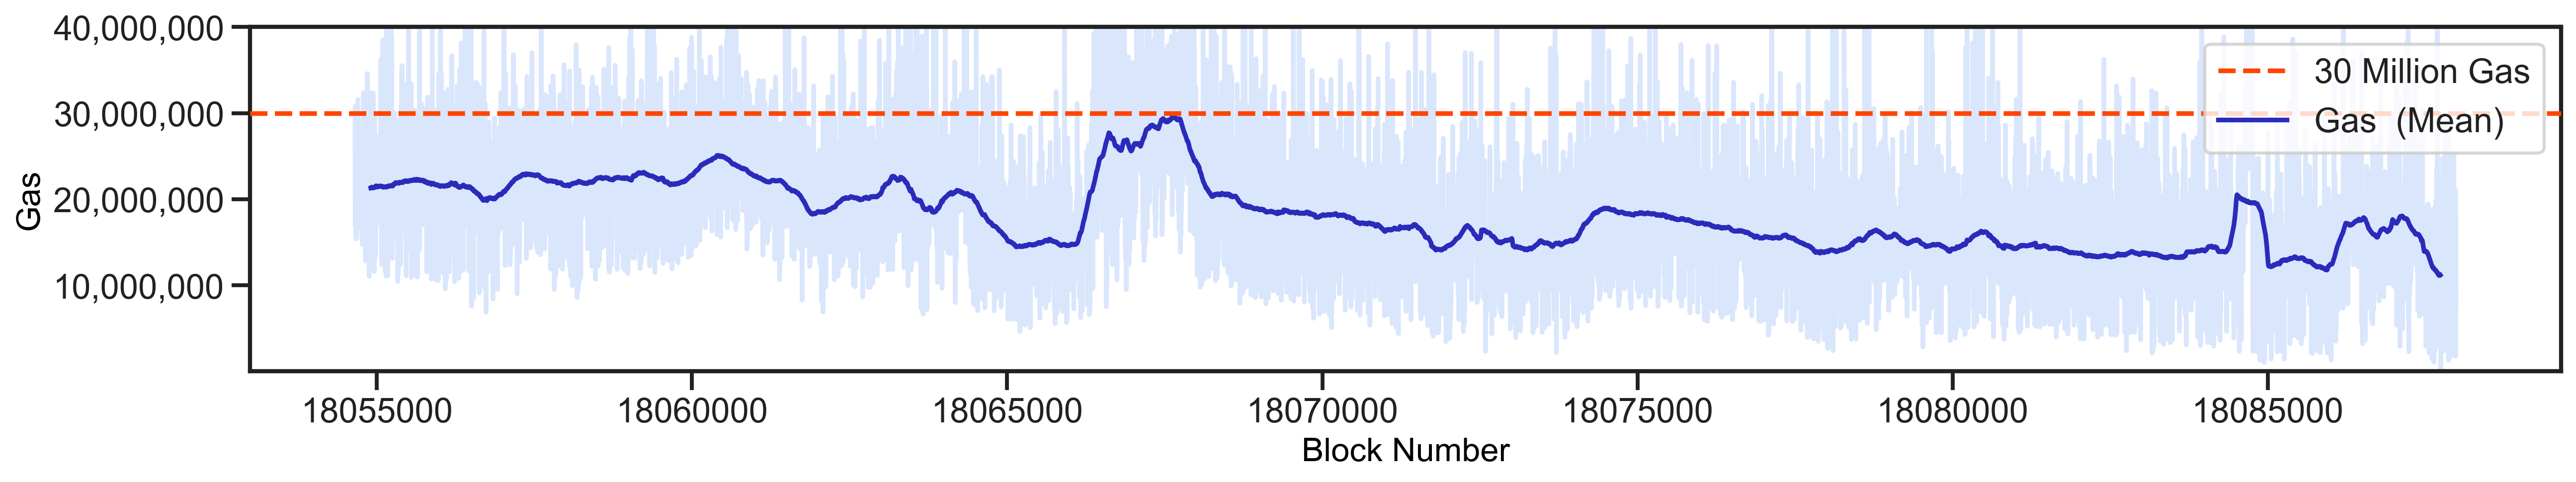

In [17]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')

fig, ax1 = plt.subplots(figsize=(20, 3), dpi=300)

# Create a rolling mean column with a larger window
# Plot the 'GUPB' on the first y-axis (left) with the rolling mean (moving average)
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()
ax1.plot(includable_df['Block'], includable_df['GUPB'],alpha = 0.2, color = palette[1])
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Gas  (Mean)', color = palette[3]) 

# Axis 
ax1.set_ylabel('Gas', color='black', fontsize=16)
ax1.set_xlabel('Block Number', color='black', fontsize=16)
ax1.set_ylim(0, 40000000)
ax1.set_yticks([10000000, 20000000, 30000000, 40000000]) 
# ax1.set_ylim(0, 110000000)
# ax1.set_yticks([10000000, 30000000, 50000000, 70000000, 90000000])

# Style
ax1.tick_params(axis='both', colors=palette[2])
ax1.ticklabel_format(style='plain')
ax1.set_facecolor('white')
ax1.grid(False)

# Plot a horizontal line to mark 30 million gas
ax1.axhline(30000000, linestyle='--', label='30 Million Gas', zorder=4, color = 'orangered' )

# Set the spines to black
for spine in ax1.spines.values():
    spine.set_edgecolor(palette[2])
    spine.set_linewidth(2)

# Define a function to format y-axis labels
def comma_format(x, pos):
    return '{:,}'.format(int(x))

# Create a formatter
formatter = FuncFormatter(comma_format)
ax1.yaxis.set_major_formatter(formatter)

# Get legend handles and labels for both axes
handles, labels = ax1.get_legend_handles_labels()

# Move '30 Million Gas' handle and label
index = labels.index('30 Million Gas')
handle = handles.pop(index)
label = labels.pop(index)
handles.insert(0, handle)
labels.insert(0, label)

# Create a single legend
legend = ax1.legend(handles, labels, loc='upper right', facecolor='white')
for text in legend.get_texts():
    text.set_color(palette[2])

# Set the color of the tick lines on both axes to black
ax1.tick_params(axis='both', colors=palette[2])
ax1.tick_params(axis='x', colors=palette[2])


plt.show()
fig.savefig('../figures/includable_gas_last_few_days.png', dpi=300, bbox_inches='tight', transparent=True)
plt.close()

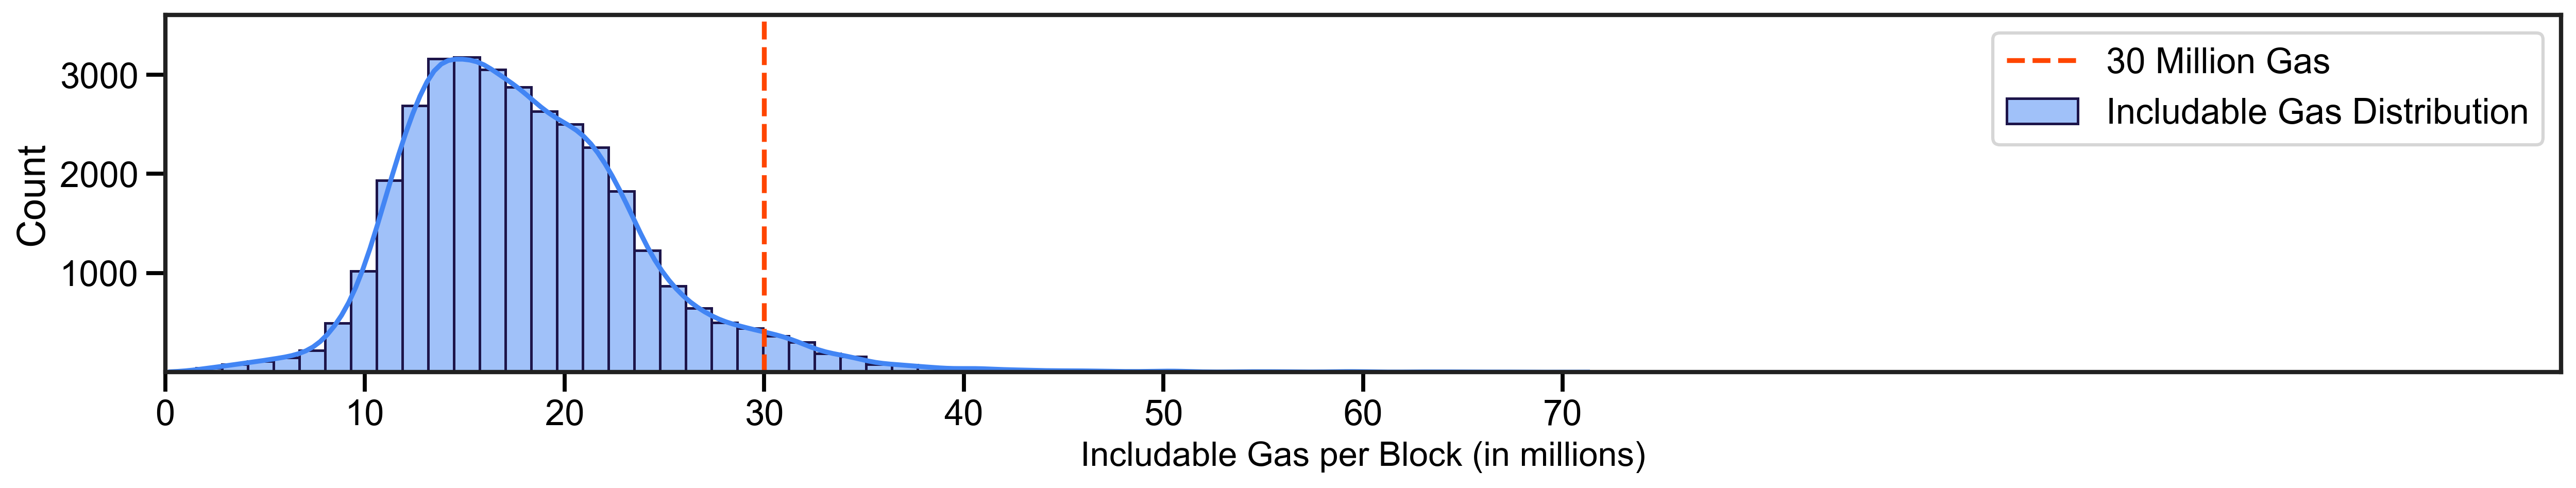

In [18]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')


fig, ax = plt.subplots(figsize=(20, 3), dpi=300)

# sns.histplot(includable_df['GUPB'], bins='auto', kde=True, edgecolor=palette[0], linewidth=1.2, color=palette[1], label='Includable Gas Distribution')
sns.histplot(includable_df['GUPB'], bins=55, kde=True, edgecolor=palette[0], linewidth=1.2, color=palette[1], label='Includable Gas Distribution')
plt.axvline(30000000, linestyle='--', label='30 Million Gas', color = 'orangered') 

plt.xticks(np.arange(0, includable_df['GUPB'].max(), 10000000)) 
plt.xlim(0, 120000000)
# plt.ylim(0, 2200)
# ax.set_yticks([500,1000,1500,2000])
plt.ylim(0, 3600)
ax.set_yticks([1000,2000,3000])

plt.xlabel('Includable Gas per Block', color='black', fontsize=16)
plt.ticklabel_format(style='plain')

# Define a function to format x-axis labels
def comma_format(x, pos):
    # Divide by 1,000,000, round to the nearest integer, and format
    return '{:,}'.format(int(round(x / 1000000)))

# Create a formatter
formatter = FuncFormatter(comma_format)

# Get the current axes
ax = plt.gca()

# Set the formatter for the x-axis
ax.xaxis.set_major_formatter(formatter)
ax.grid(False)
ax.set_facecolor('white')

# Set the spines to black
for spine in ax.spines.values():
    spine.set_edgecolor(palette[2])
    spine.set_linewidth(2)

# show legend
plt.legend(loc='upper right', facecolor='white')

plt.xlabel('Includable Gas per Block (in millions)', color='black', fontsize=16)

plt.savefig('../figures/includable_gas_distribution_last_few_days.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
plt.close()

In [15]:
print("Percentage of Includable Gas per Block >= 30 Million")
free_gas = len(includable_df[includable_df['GUPB'] >= 30000000]) / len(includable_df) * 100
print("{:.2f}%".format(free_gas))

Percentage of Includable Gas per Block >= 30 Million
87.35%


## Cost analysis

Assumption: block reward for builder is ~2 ETH. (https://bitinfocharts.com/ethereum/)

In [19]:
# Load the lists of curblocknumber, basefeepergas
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

curblocknumber = np.array(curblocknumber)
basefeepergas = np.array(basefeepergas)

block_gas_dict = {block: gas for block, gas in zip(curblocknumber, basefeepergas)}

In [20]:
# load results
with open('includable_gas_arrays.pickle', 'rb') as f:
    offset, gpb, gupb, txns = pickle.load(f)

# put oresults into a dataframe
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

In [21]:
# create a new column ['stuffing deficit'] in includable df that is 30,000,000 - the GUPB. if ['stuffing deficit'] < 0, then 0
includable_df['stuffing deficit'] = 30000000 - includable_df['GUPB']
includable_df['stuffing deficit'] = np.where(includable_df['stuffing deficit'] < 0, 0, includable_df['stuffing deficit'])

includable_df['BFPG'] = includable_df['Block'].map(block_gas_dict)

# create a new column includable_df['stuffing cost'] = includable_df['stuffing deficit'] * includable_df['basefeepergas']
includable_df['stuffing cost'] = includable_df['stuffing deficit'] * includable_df['BFPG']

includable_df['stuffing cost ETH'] = includable_df['stuffing cost'] / (1e18)

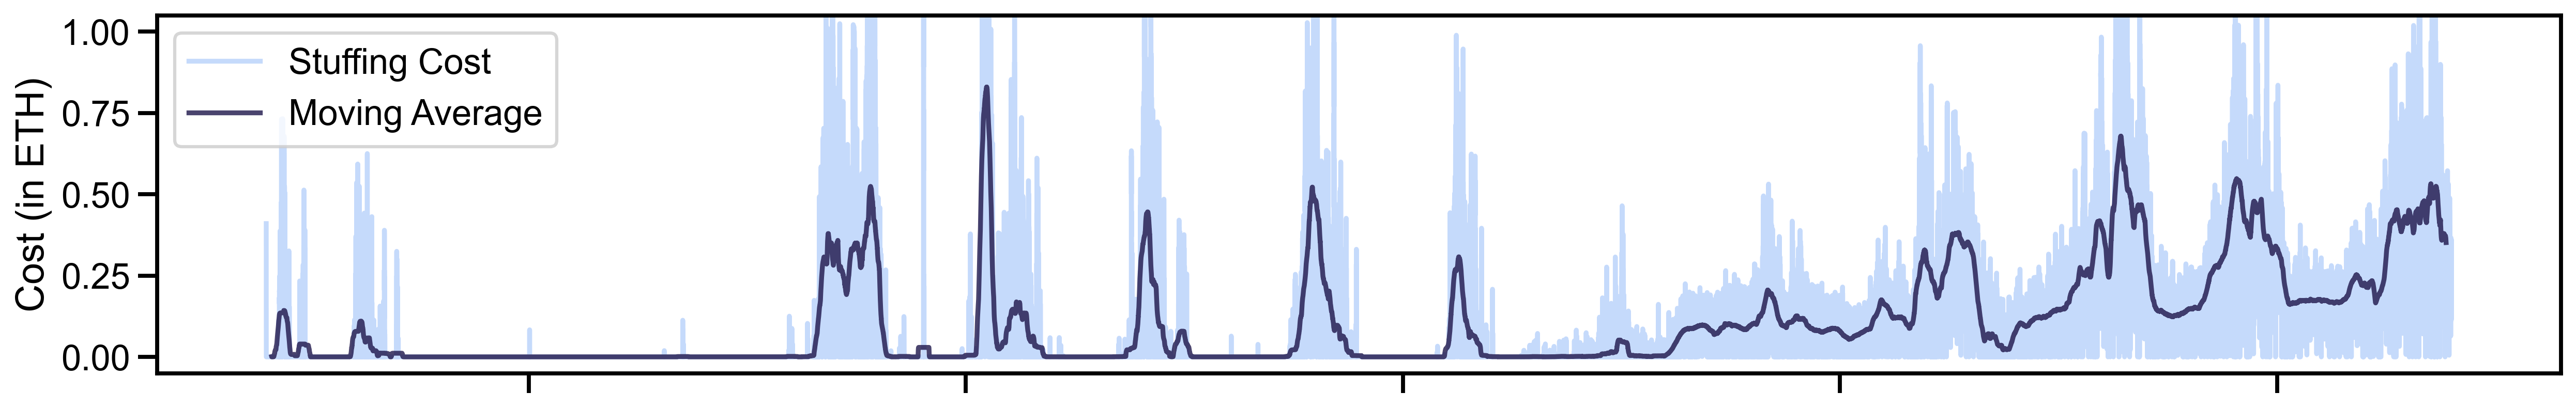

In [23]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')

includable_df['Rolling Mean stuffing cost ETH'] = includable_df['stuffing cost ETH'].rolling(window=500, center=True).mean()

plt.figure(figsize=(20, 3), dpi=300)

plt.plot(includable_df['Block'], includable_df['stuffing cost ETH'], label='Stuffing Cost', color = palette[1], alpha=0.3)
plt.plot(includable_df['Block'], includable_df['Rolling Mean stuffing cost ETH'], label='Moving Average', color = palette[0], alpha=0.8)

# plt.xlabel('Block Number')

plt.ylabel('Cost (in ETH)')
plt.ylim(-0.05, 1.05)

# Get the current axes
ax = plt.gca()

# Set the x-axis tick labels to plain
ax.ticklabel_format(axis='x', style='plain')

# hide x-axis labels
ax.set_xticklabels([])

plt.legend()

# save fig at 400 dpi
plt.savefig('../figures/stuffing_cost_eth.png', dpi=300, bbox_inches='tight', transparent=True)

In [24]:
# Add 'bfpg' column to 'includable_df'
includable_df['bfpg'] = includable_df['Block'].map(block_gas_dict)
includable_df['bfpg_gwei'] = includable_df['bfpg'] / (1e9)

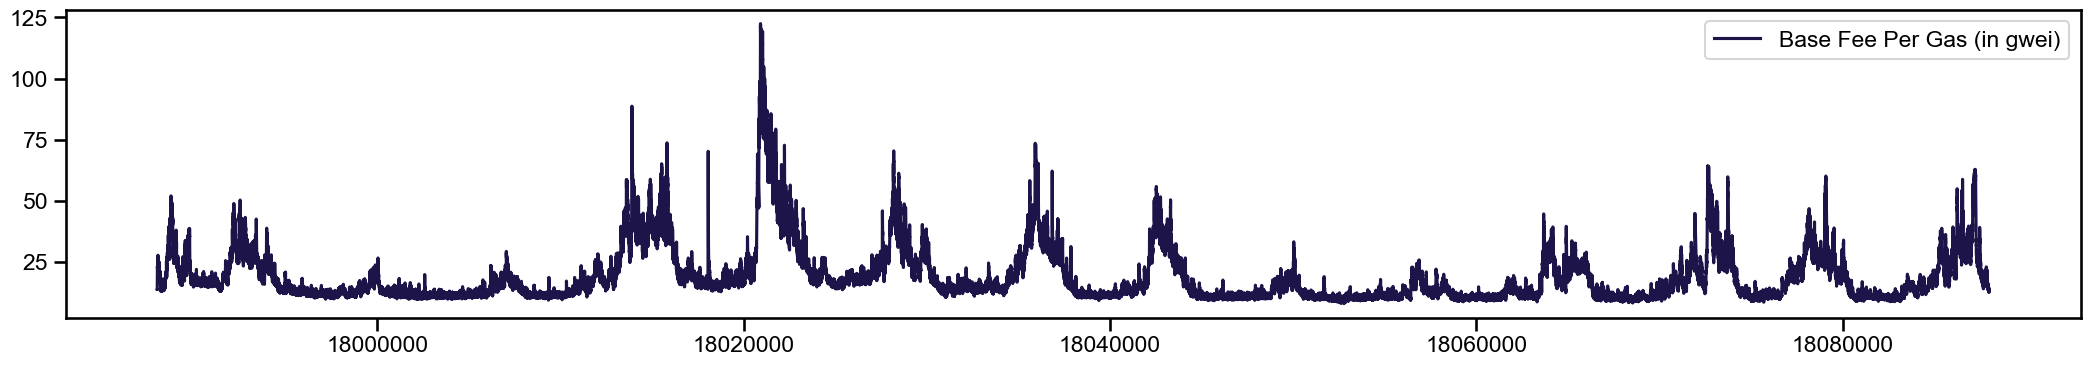

In [26]:
sns.set_context('talk')
fig, ax1 = plt.subplots(figsize=(26, 4))

ax1.plot(includable_df['Block'], includable_df['bfpg_gwei'], label='Base Fee Per Gas (in gwei)', color = palette[0])

# Define a function to format y-axis labels
def comma_format(x, pos):
    return '{:,}'.format(int(x))

# Create a formatter
formatter = FuncFormatter(comma_format)
ax1.yaxis.set_major_formatter(formatter)

# Get the current axes
ax1 = plt.gca()

# Set the x-axis tick labels to plain
ax1.ticklabel_format(axis='x', style='plain')

plt.legend()

# save fig at 400 dpi
plt.savefig('bfpg_per_block.png', dpi=400, bbox_inches='tight')

In [27]:
# get the average base fee per gas 
print("Average Base Fee Per Gas")
print(includable_df['bfpg_gwei'].mean())


Average Base Fee Per Gas
18.852073300873833


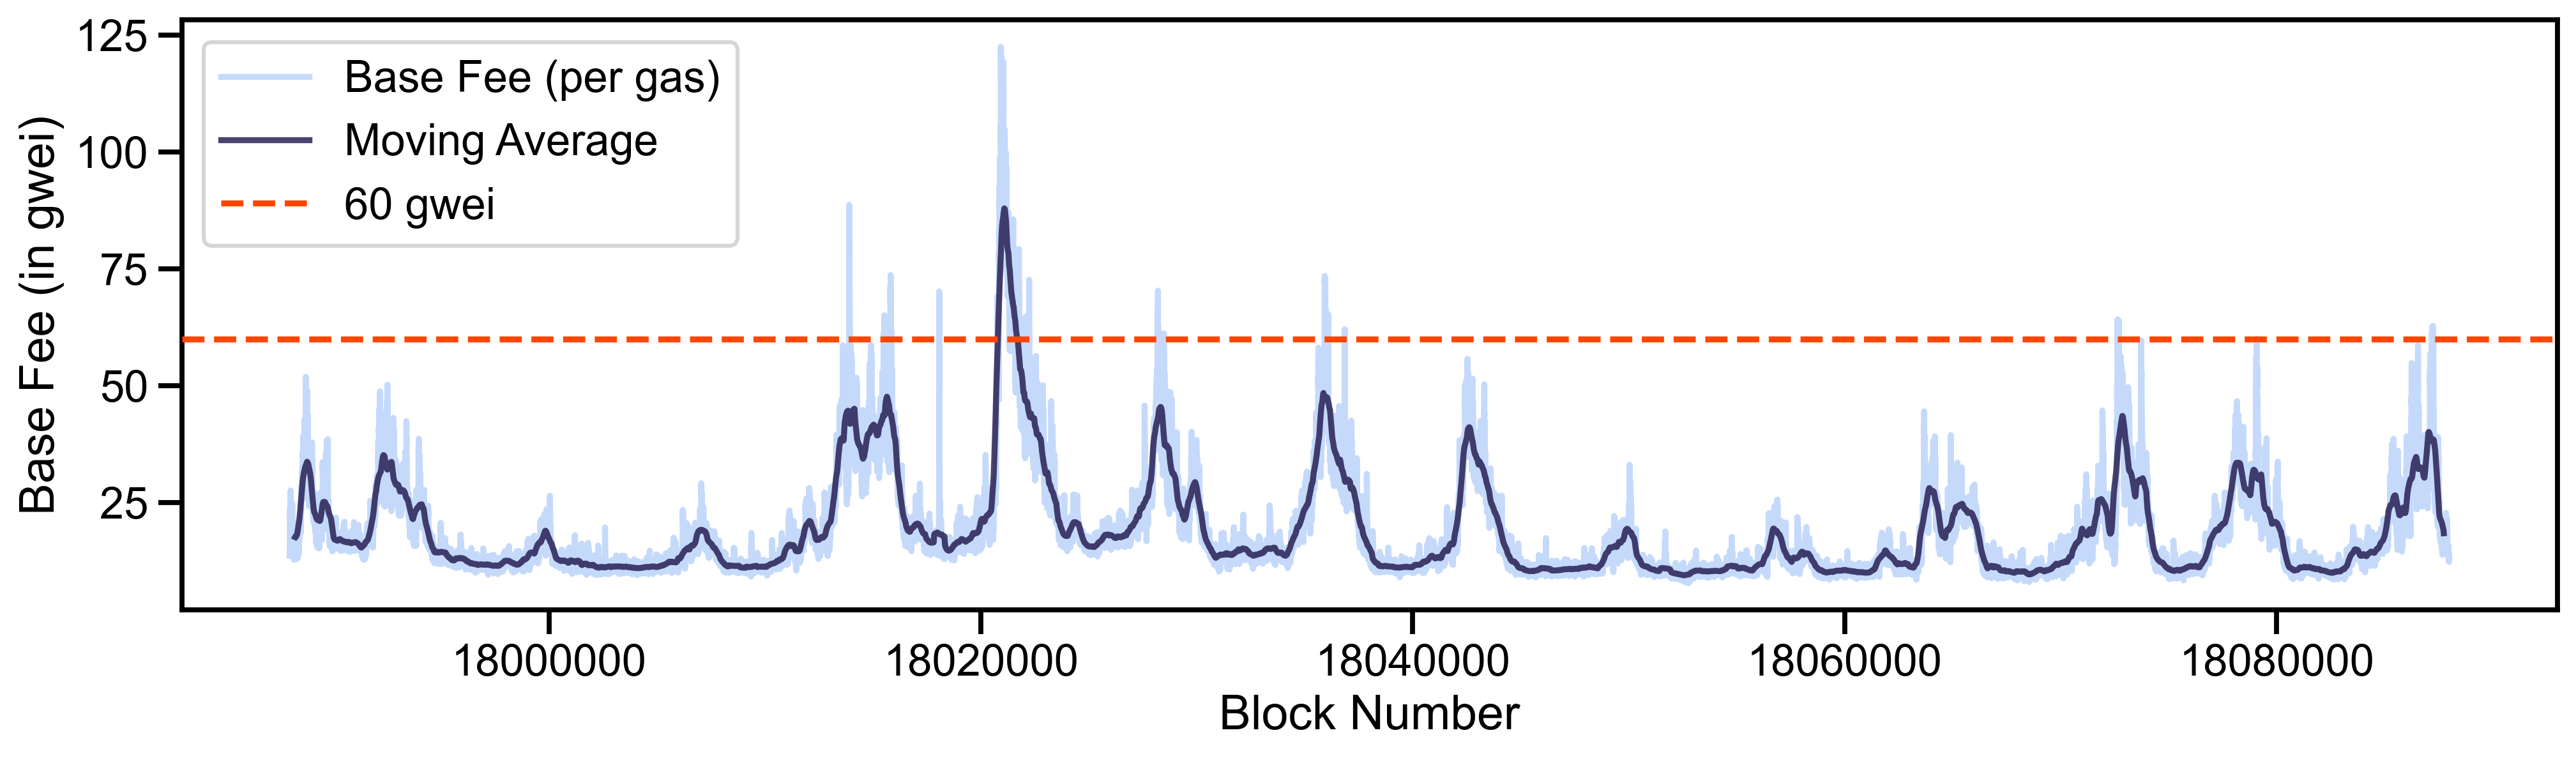

In [28]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')

includable_df['Rolling Mean bfpg_gwei'] = includable_df['bfpg_gwei'].rolling(window=500, center=True).mean()

plt.figure(figsize=(16,4), dpi=300)

plt.plot(includable_df['Block'], includable_df['bfpg_gwei'], label='Base Fee (per gas)', color = palette[1], alpha=0.3)
plt.plot(includable_df['Block'], includable_df['Rolling Mean bfpg_gwei'], label='Moving Average', color = palette[0], alpha = 0.8)

plt.axhline(60, linestyle='--', label='60 gwei', zorder=4, color = 'orangered' )

plt.xlabel('Block Number')

plt.ylabel('Base Fee (in gwei)')
# plt.ylim(-0.05, 1.05)

# Get the current axes
ax = plt.gca()

# Set the x-axis tick labels to plain
ax.ticklabel_format(axis='x', style='plain')

plt.legend(loc='upper left')

# save fig at 400 dpi
plt.savefig('../figures/bfpgpb.png', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# get the average base fee per gas 
print("Average Base Fee Per Gas")
print(includable_df['bfpg_gwei'].mean())

# median base fee per gas
print("Median Base Fee Per Gas")
print(includable_df['bfpg_gwei'].median())

In [39]:
# Initialize base fee
base_fee = 19

# Initialize list of base fees
base_fees = [base_fee]

# Calculate base fees for 10 steps
for i in range(1, 15):
    base_fee += base_fee * 0.125
    base_fees.append(base_fee)

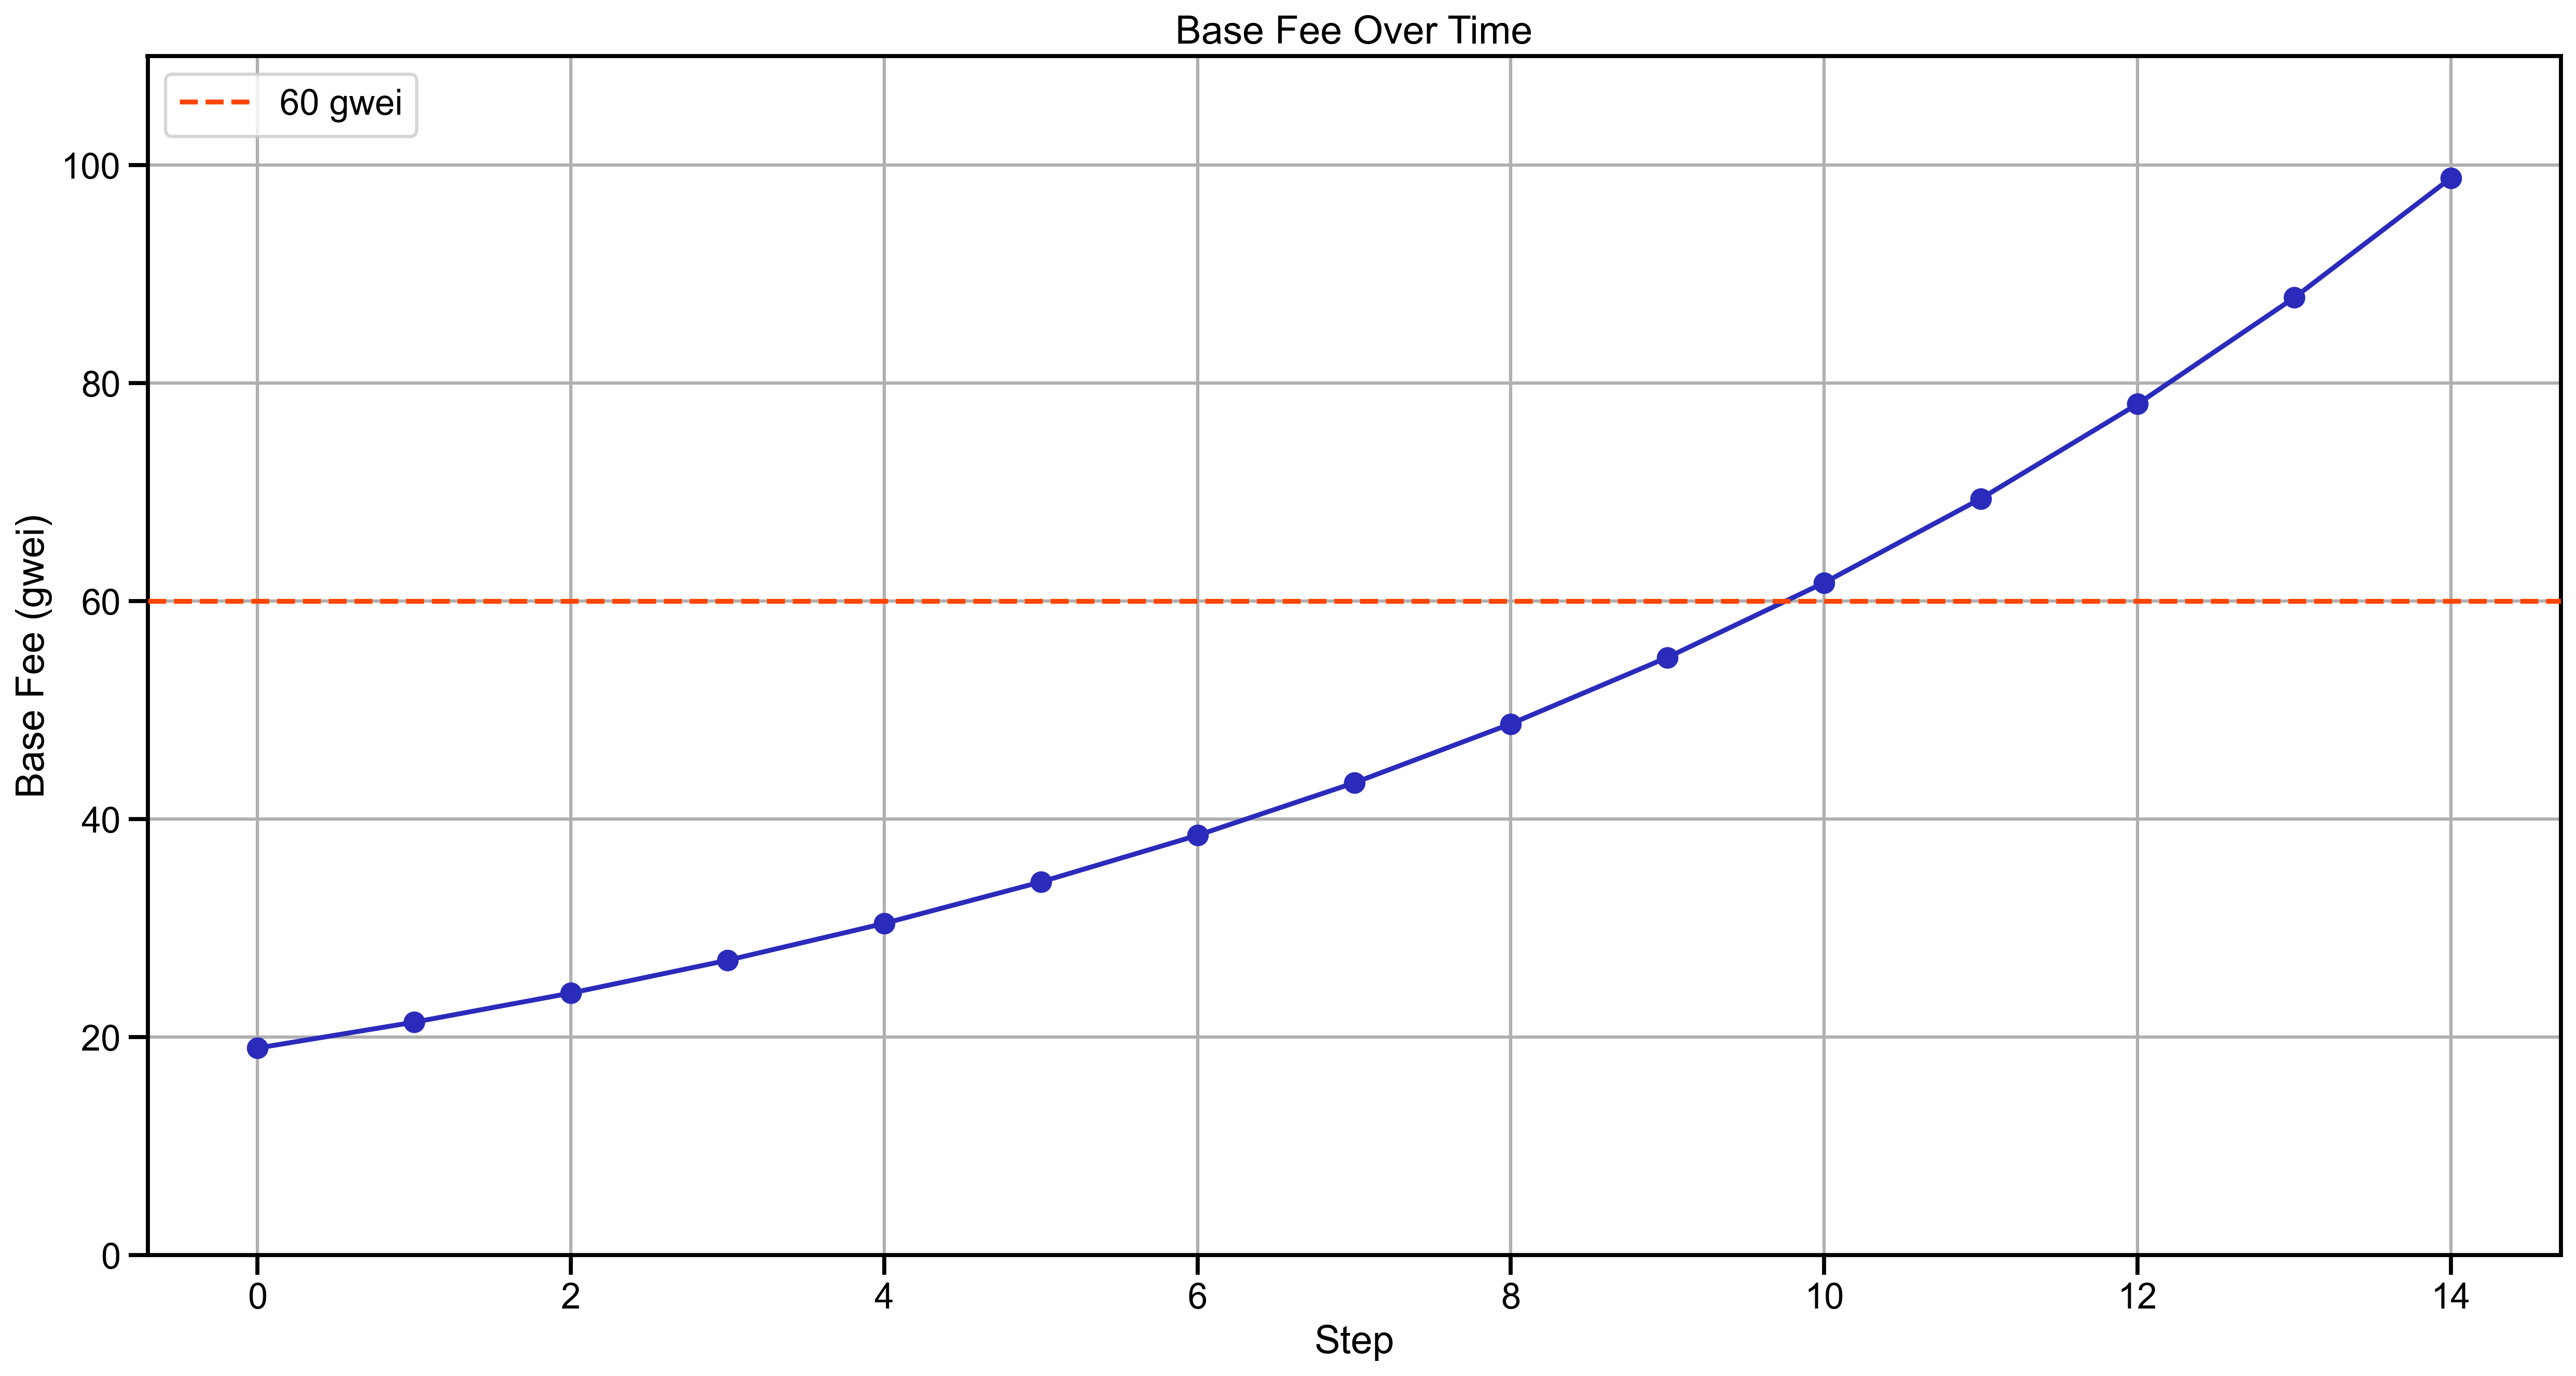

In [62]:
plt.rcParams['font.family'] = 'Arial'
sns.set_context('talk')

plt.figure(figsize=(20,10), dpi=300)

plt.plot(base_fees, marker='o', color = palette[3])

plt.axhline(60, linestyle='--', label='60 gwei', zorder=4, color = 'orangered' )

plt.title('Base Fee Over Time')
plt.xlabel('Step')
plt.ylabel('Base Fee (gwei)')
plt.grid(True)

plt.ylim(0,110)
# Get the current axes
ax = plt.gca()

# Set the x-axis tick labels to plain
ax.ticklabel_format(axis='x', style='plain')

plt.legend(loc='upper left')

# save fig at 400 dpi
plt.savefig('../figures/consecutive_blocks.png', dpi=300, bbox_inches='tight', transparent=True)
# plt.show()